<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3c_OSI_SAF_sea_ice_mapping_ice_type.ipynb" target="_blank"><< Mapping OSI SAF sea ice type</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=".1_4_OSI_SAF_sea_ice_THREDDS_example.ipynb" target="_blank">Accessing and mapping OSI SAF sea ice data via THREDDS >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sea-ice/HEAD?urlpath=%2Ftree%2F1_OSI_SAF_sea_ice_introductory%2F1_3d_OSI_SAF_sea_ice_mapping_ice_drift.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea ice parameters : Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank">1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb</a>**

</div>
<hr>

# 1.3d Mapping OSI SAF sea ice drift 
### Data used 

| Product Description | Product Navigator | OSI SAF website link | OSI SAF Identifier |
|:--------------------:|:-------------:|:-----------------:|:-----------------:|
| Global Low Resolution Sea Ice Drift | EO:EUM:DAT:MULT:GBL-LR-SIDR | <a href="https://osi-saf.eumetsat.int/products/osi-405-c" target="_blank">link</a> | OSI-405-c | 


### Learning outcomes

At the end of this notebook you will know;
* How to open Sea Ice Drift netcdf
* Map Sea Ice Drift using cartopy 

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Mapping sea ice concentration - Northern Hemisphere](#section1)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                                     # a library that allows us access to basic operating system commands
import xarray as xr                           # a library that supports the use of multi-dimensional arrays in Python
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean                                # colormaps for ocean products
import cmcrameri                              # scientific colormaps for data visualisation
from netCDF4 import Dataset as NetCDFFile 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Mapping sea ice drift - Northern Hemisphere
[Back to top](#TOC_TOP)

</div>

Setting directory where to read data files

In [2]:
directory = 'products/sea_ice_drift/nh'

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [3]:
#cmap = cmocean.cm.ice
#cmap = cmcrameri.cm.oslo
cmap = mpl_cm.get_cmap('inferno')

Sea Ice Drift data has a specific projection. We can explore the netcdf file to find the characteristics.

In [4]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)

In [5]:
nc

<xarray.Dataset>
Dimensions:                   (time: 1, nv: 2, xc: 119, yc: 177)
Coordinates:
  * time                      (time) datetime64[ns] 2023-02-05T12:00:00
  * xc                        (xc) float64 -3.75e+03 -3.688e+03 ... 3.625e+03
  * yc                        (yc) float64 5.75e+03 5.688e+03 ... -5.25e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Polar_Stereographic_Grid  int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    dt0                       (time, yc, xc) timedelta64[ns] ...
    lon1                      (time, yc, xc) float32 ...
    lat1                      (time, yc, xc) float32 ...
    dt1                       (time, yc, xc) timedelta64[ns] ...
    dX                        (time, yc, xc) float32 ...
    dY                        (time, yc, xc) float32 ...
    status_flag               (time, yc, xc) int8 ...
    uncert_dX_and_dY          (time, yc, xc) float32 ...
Attributes: (12/30)
    title:                   Daily Low Resolution Sea Ice Displacement from O...
    product_id:              OSI-405
    product_name:            osi_saf_lr_ice_drift
    product_status:          operational
    abstract:                Gridded ice displacement fields obtained from  s...
    topiccategory:           Oceans ClimatologyMeteorologyAtmosphere
    ...                      ...
    references:              Product User Manual for OSI-405-c, Lavergne, v1....
    history:                 2023-02-06 creation
    product_version:         2.0
    software_version:        5.1
    netcdf_version:          3.6.3
    Conventions:             CF-1.4

Setting geographical area.

In [6]:
lon_min = 15
lon_max = 175
lat_min = 50
lat_max = 90

Mapping figure based on retrieved netcdf file.

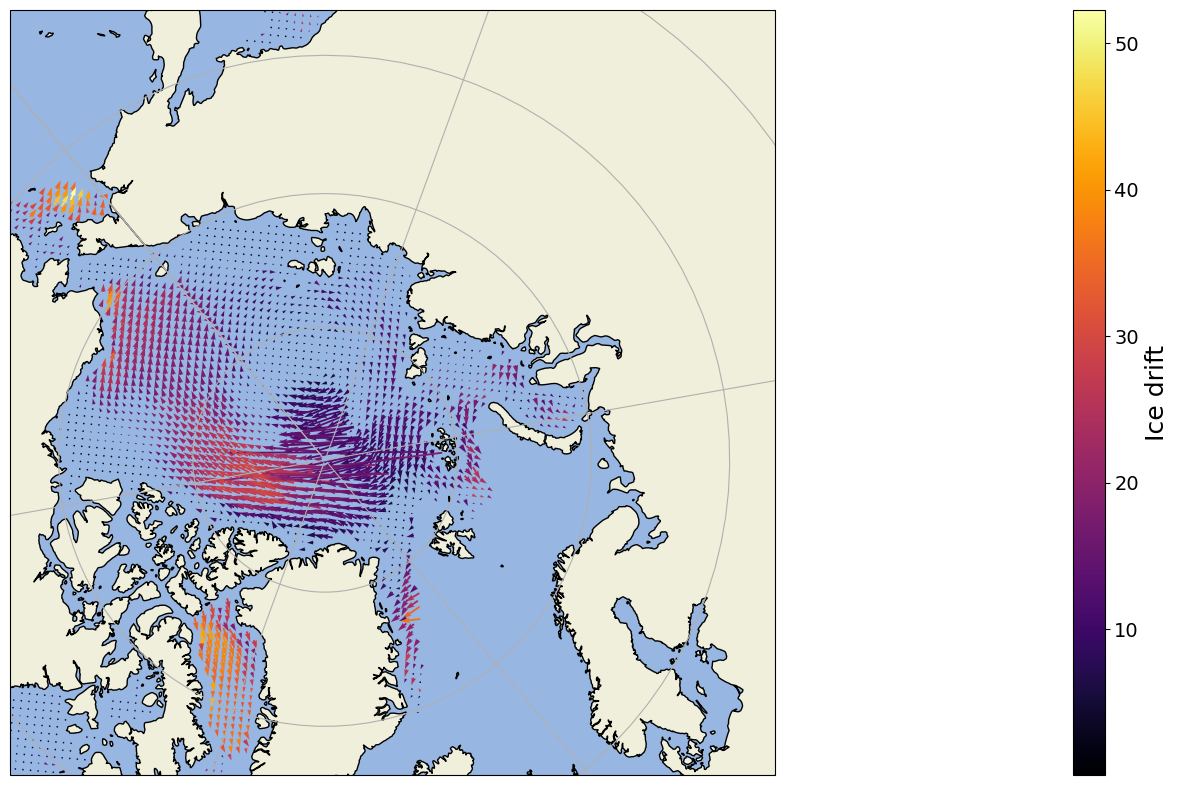

In [26]:
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.NorthPolarStereo(-40)

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.gridlines()

# open and plot data
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = NetCDFFile(directory + '/' + filename)
        xc = nc.variables['xc'][:] 
        yc = nc.variables['yc'][:] 
        lat = nc.variables['lat'][:]   
        lon = nc.variables['lon'][:]
        lat1 = nc.variables['lat1'][:]   
        lon1 = nc.variables['lon1'][:]
        dX = nc.variables['dX'][:]
        dY = nc.variables['dY'][:]
        status_flag = nc.variables['status_flag'][:]
        nc.close()
        
        # Sea Ice drift data is provided in x y coordinates, we calculate it in lat/lon in this example for cartopy
        u = lon1[0,:,:]-lon[:,:]
        u[u>180] = 360 - u[u>180]
        
        v = lat1[0,:,:]-lat[:,:]
        vect = pow(dX,2)+pow(dY,2)
        speed = np.sqrt(np.squeeze(vect))

        #Small quality control
        u[u < -50] = np.nan ; u[u > 50] = np.nan
        v[v < -50] = np.nan ; v[v > 50] = np.nan
        
        # plotting sea drift
        stride = 1
        im = ax.quiver(lon[::stride,::stride], lat[::stride,::stride],
                       u[::stride,::stride], v[::stride,::stride], speed[::stride,::stride],
                       transform=data_projection, cmap=cmap, linewidth=30, pivot='mid', scale=50.0)

# Adding a colorbar       
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('Ice drift', fontsize=18)
cb.ax.tick_params(labelsize=14)

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3c_OSI_SAF_sea_ice_mapping_ice_type.ipynb" target="_blank"><< Mapping OSI SAF sea ice type</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href=".1_4_OSI_SAF_sea_ice_THREDDS_example.ipynb" target="_blank">Accessing and mapping OSI SAF sea ice data via THREDDS >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>